In [463]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [464]:
df = pd.read_csv('./output/data/features.csv')

In [465]:
df.columns

Index(['file_path', 'sampling_rate', 'label', 'mfcc_1_mean', 'mfcc_2_mean',
       'mfcc_3_mean', 'mfcc_4_mean', 'mfcc_5_mean', 'mfcc_6_mean',
       'mfcc_7_mean', 'mfcc_8_mean', 'mfcc_9_mean', 'mfcc_10_mean',
       'mfcc_11_mean', 'mfcc_12_mean', 'mfcc_13_mean', 'chroma_1_mean',
       'chroma_2_mean', 'chroma_3_mean', 'zcr_mean',
       'spectral_contrast_1_mean', 'spectral_contrast_2_mean',
       'spectral_contrast_3_mean', 'spectral_contrast_4_mean',
       'spectral_contrast_5_mean', 'spectral_contrast_6_mean',
       'spectral_centroid_mean', 'spectral_bandwidth_mean',
       'spectral_rolloff_mean', 'lpc_1_mean', 'lpc_2_mean', 'lpc_3_mean',
       'lpc_4_mean', 'lpc_5_mean', 'lpc_6_mean', 'lpc_7_mean', 'lpc_8_mean',
       'lpc_9_mean', 'lpc_10_mean', 'lpc_11_mean', 'lpc_12_mean'],
      dtype='object')

In [466]:
# Drop the 'file_path' column
data = df.drop(columns=['file_path', 'sampling_rate'])

# Convert 'label' column values from 'fake' and 'real' to 0 and 1
data['label'] = data['label'].apply(lambda x: 0 if x == 'fake' else 1)

# Display the updated dataframe
data.head()

,label,mfcc_1_mean,mfcc_2_mean,mfcc_3_mean,mfcc_4_mean,mfcc_5_mean,mfcc_6_mean,mfcc_7_mean,mfcc_8_mean,mfcc_9_mean,...,lpc_3_mean,lpc_4_mean,lpc_5_mean,lpc_6_mean,lpc_7_mean,lpc_8_mean,lpc_9_mean,lpc_10_mean,lpc_11_mean,lpc_12_mean
0,1,-306.802601,141.978490,-37.929007,14.289347,-0.107969,-24.521714,-10.573670,-22.349943,-29.737671,...,0.592400,0.195840,-0.040913,0.010450,0.061502,0.066491,0.031174,-0.014593,0.020835,0.021316
1,1,-264.070986,126.647754,-79.588862,8.555920,3.356235,-30.609927,-13.310042,-24.338574,-21.259028,...,0.713361,0.276484,-0.143440,-0.029000,0.131137,0.084664,0.007185,-0.008404,0.058873,0.007753
2,1,-291.072813,109.180046,-79.704942,24.694131,4.836306,-39.720305,-18.803889,-21.149926,-23.722638,...,0.857493,0.153646,-0.086110,0.045050,0.122375,0.064725,0.015537,0.016502,0.050555,-0.007840
3,0,-342.665518,119.439529,-23.393930,12.865031,16.970731,-28.972598,-21.764271,-10.775513,-22.671833,...,0.392484,0.323278,0.049570,-0.042062,0.017126,0.071615,0.059133,0.012361,-0.009716,0.041989
4,1,-272.012200,133.841561,-75.479054,-6.655172,-2.764077,-38.122417,-25.923031,-24.451943,-30.052075,...,0.652804,0.265383,-0.139068,-0.026900,0.070140,-0.009709,0.018877,0.053708,-0.026394,0.010536


In [467]:
data.shape

(15475, 39)

In [468]:
# 1. Load and preprocess data
features = data.drop(columns=['label', 'lpc_1_mean', 'lpc_10_mean', 'lpc_11_mean', 'lpc_12_mean', 'mfcc_3_mean', 'mfcc_2_mean',
                              'spectral_centroid_mean', 'spectral_bandwidth_mean', 'spectral_rolloff_mean',
                              'spectral_contrast_1_mean', 'spectral_contrast_2_mean', 'spectral_contrast_3_mean',
                              'spectral_contrast_4_mean', 'spectral_contrast_5_mean', 'spectral_contrast_6_mean', 'chroma_1_mean',
                              'chroma_2_mean', 'chroma_3_mean', 'zcr_mean'], axis=1).copy()
labels = data['label']

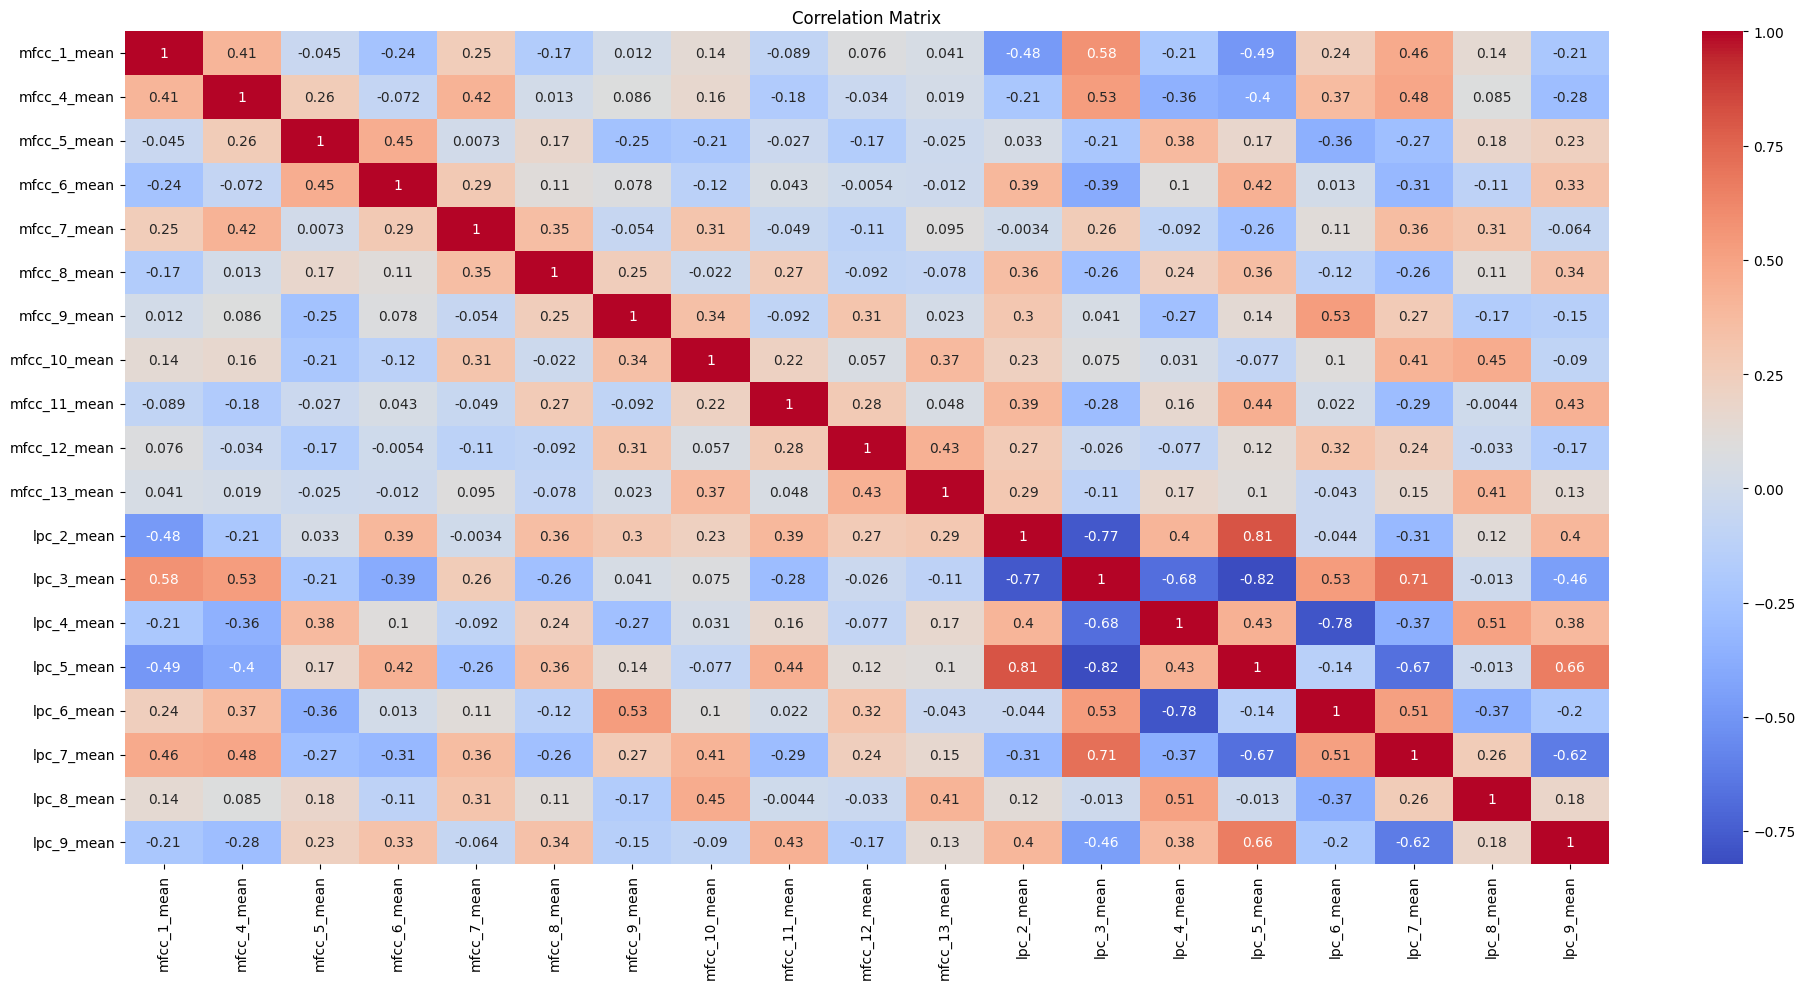

In [469]:
correlation_matrix = features.corr()
plt.figure(figsize=(20, 10))
sns.heatmap(correlation_matrix, cmap='coolwarm', annot = True)
plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()

In [470]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Input, LSTM, Bidirectional, Dropout, Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.regularizers import l2
from keras.optimizers import Adam
from keras.losses import BinaryCrossentropy

In [471]:
def create_sequences(features, sequence_length, overlap):
    """
    Creates sequences from feature data.

    Args:
        features: A NumPy array of shape (num_samples, num_features).
        sequence_length: The desired length of each sequence.
        overlap: The number of overlapping features between consecutive sequences.

    Returns:
        A tuple containing:
            - A NumPy array of shape (num_sequences, sequence_length, num_features).
            - A list of indices indicating the starting sample of each sequence.
    """
    sequences = []
    indices = []  # Store the starting index of each sequence
    for i in range(0, len(features) - sequence_length + 1, sequence_length - overlap):
        sequences.append(features[i: i + sequence_length])
        indices.append(i)  # Store the starting index
    return np.array(sequences), indices

In [472]:
# 1. Create sequences
sequence_length = 10  # Example value, adjust as needed
overlap = 5  # Example value, adjust as needed
sequences, indices = create_sequences(features, sequence_length, overlap)
labels = labels[indices]

# 2. Pad sequences
padded_sequences = pad_sequences(
    sequences, maxlen=sequence_length, padding="pre", truncating="post"
)

# Scale features
scaler = StandardScaler()

# Reshape padded_sequences for scaling
num_samples, seq_len, num_features = padded_sequences.shape
padded_sequences_reshaped = padded_sequences.reshape(
    num_samples, seq_len * num_features
)

# Fit and transform the scaler on the reshaped data
padded_sequences_scaled = scaler.fit_transform(padded_sequences_reshaped)

# Reshape the scaled data back to the original shape
padded_sequences = padded_sequences_scaled.reshape(
    num_samples, seq_len, num_features
)

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    padded_sequences, labels, test_size=0.2, random_state=42
)

In [473]:
# 2. Create LSTM model
model = Sequential()
input_shape = (X_train.shape[1], X_train.shape[2])
model.add(Input(shape=input_shape))
model.add(Bidirectional(LSTM(64, return_sequences=True)))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(64, return_sequences=True)))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(64, return_sequences=False)))
model.add(Dense(32, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dense(1, activation='sigmoid'))

# 3. Compile model
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="binary_crossentropy", metrics=["accuracy"])


In [474]:
# Callbacks
early_stopping = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint("best_model.keras", save_best_only=True, monitor="val_loss")
# reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=3, min_lr=0.0001)

history = model.fit(
    X_train,
    y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping, model_checkpoint],
)

Epoch 1/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 18s 208ms/step - accuracy: 0.5071 - loss: 1.0989 - val_accuracy: 0.5879 - val_loss: 0.8456
Epoch 2/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 11s 183ms/step - accuracy: 0.6083 - loss: 0.8023 - val_accuracy: 0.6424 - val_loss: 0.6996
Epoch 3/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 11s 184ms/step - accuracy: 0.6596 - loss: 0.6784 - val_accuracy: 0.6505 - val_loss: 0.6678
Epoch 4/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 11s 183ms/step - accuracy: 0.6746 - loss: 0.6320 - val_accuracy: 0.6768 - val_loss: 0.6219
Epoch 5/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 11s 180ms/step - accuracy: 0.7144 - loss: 0.5923 - val_accuracy: 0.6586 - val_loss: 0.6248
Epoch 6/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 11s 182ms/step - accuracy: 0.6985 - loss: 0.5893 - val_accuracy: 0.6606 - val_loss: 0.6314
Epoch 7/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 11s 182ms/step - accuracy: 0.7162 - loss: 0.5561 - val_accuracy: 0.6727 - val_loss: 0.6365
Epoch 8/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 11s 182ms/step - accuracy: 0.7467 - loss: 0.5463 - 

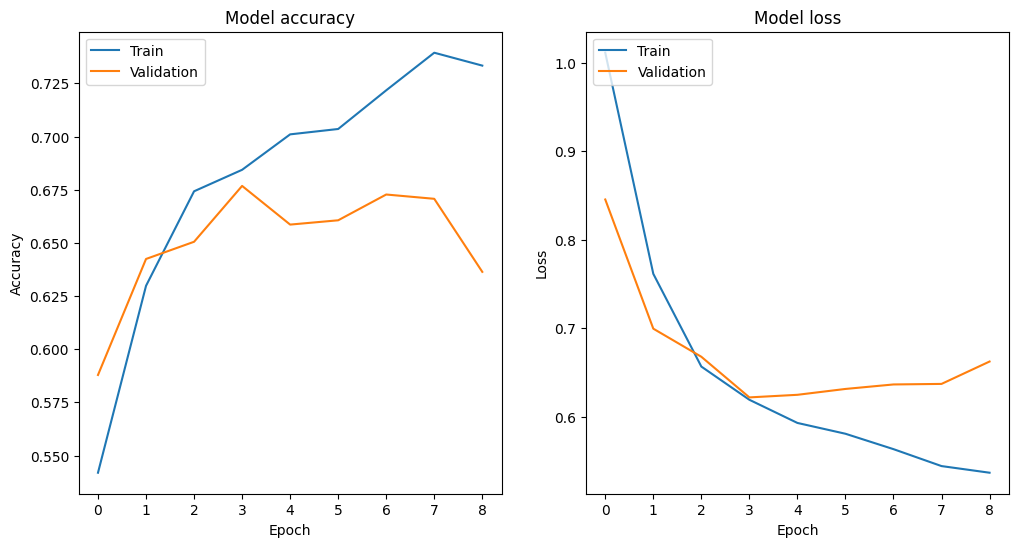

20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - accuracy: 0.7258 - loss: 0.5906
Test Loss: 0.6031696200370789
Test Accuracy: 0.6978998184204102


In [475]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

# Evaluate
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")